# Introduction to Iterative Detection and Decoding
In this notebook, you will learn how to set-up an iterative detection and decoding (IDD) scheme (first presented in [1]) by combining multiple available components in Sionna.

For a gentle introduction to MIMO simulations, we refer to the notebooks ["Simple MIMO Simulations"](https://nvlabs.github.io/sionna/examples/Simple_MIMO_Simulation.html) and ["MIMO OFDM Transmissions over CDL"](https://nvlabs.github.io/sionna/examples/MIMO_OFDM_Transmissions_over_CDL.html).

You will evaluate the performance of IDD with OFDM MIMO detection and soft-input soft-output (SISO) LDPC decoding and compare it againts several non-iterative detectors, such as soft-output LMMSE, K-Best, and expectation propagation (EP), as well as iterative SISO MMSE-PIC detection [2].

For the non-IDD models, the signal processing pipeline looks as follows:

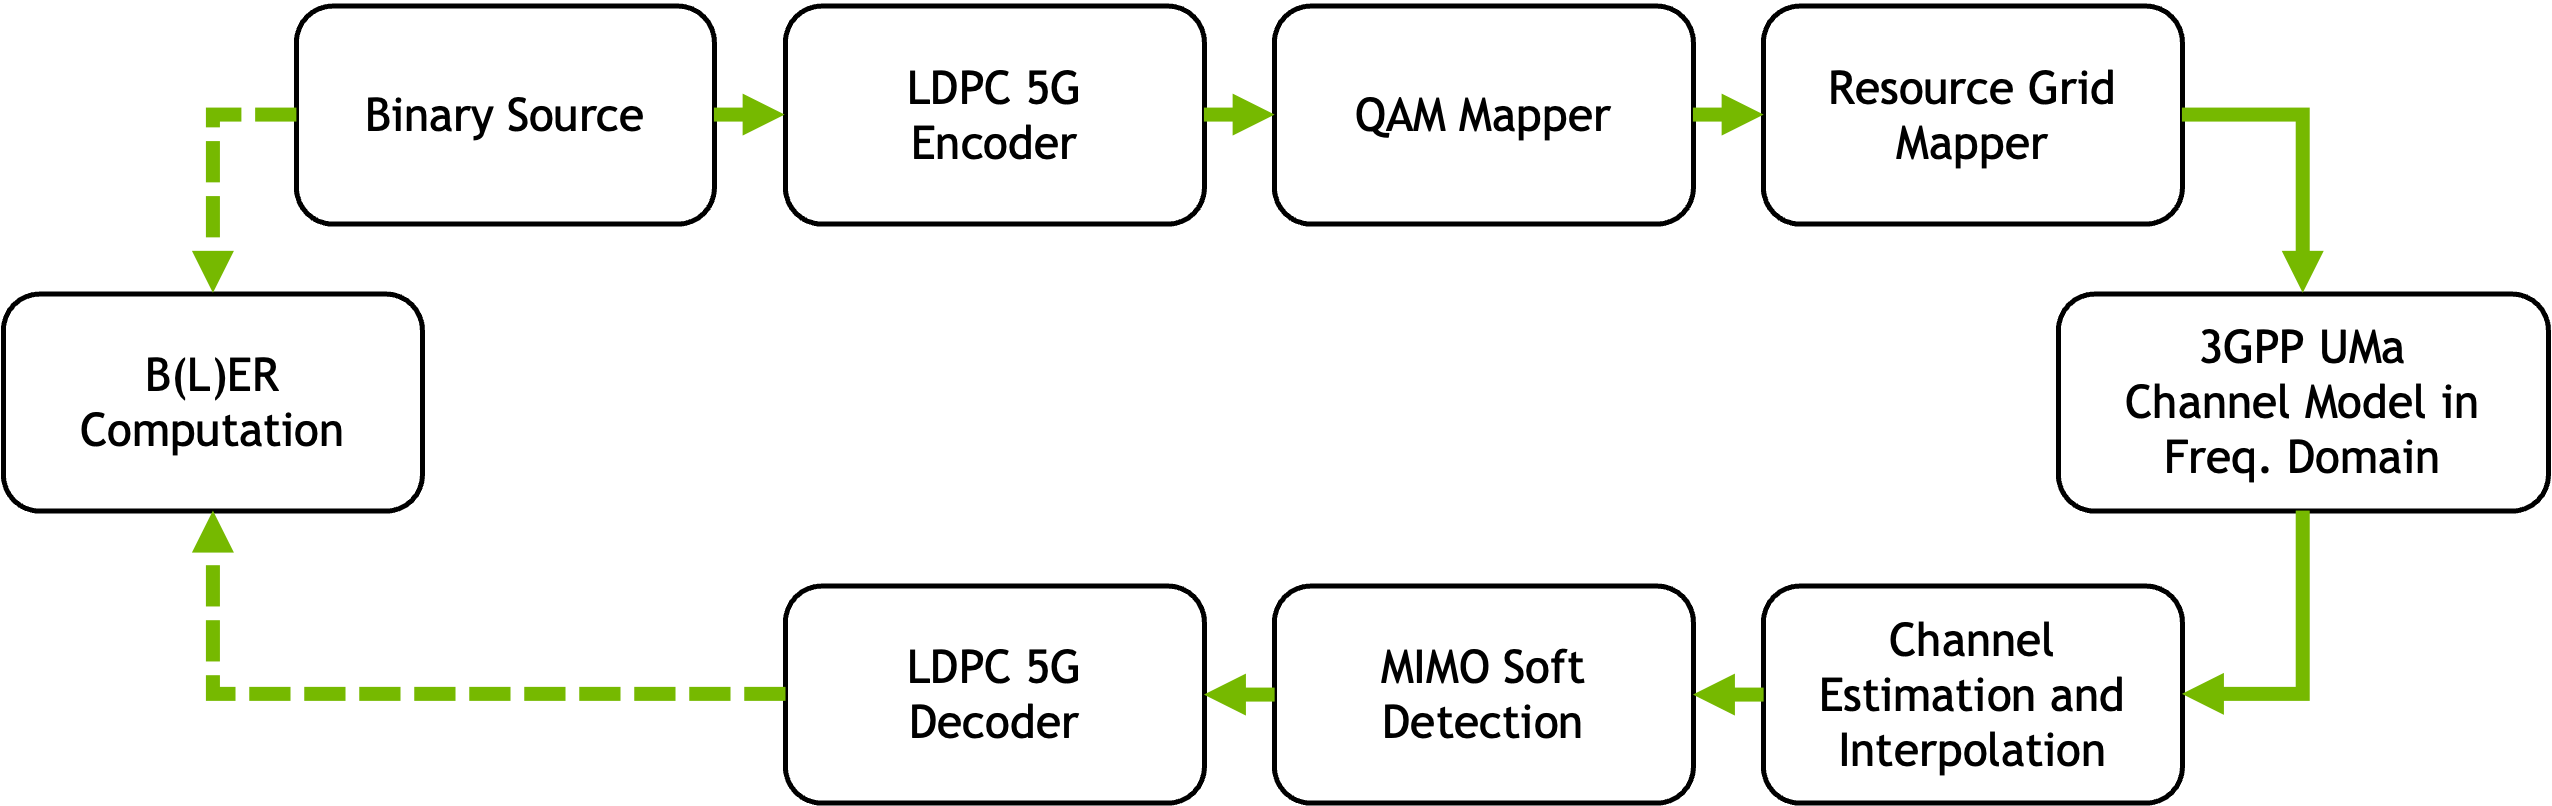

## Iterative Detection and Decoding
The IDD MIMO receiver iteratively exchanges soft-information between the data detector and the channel decoder, which works as follows:

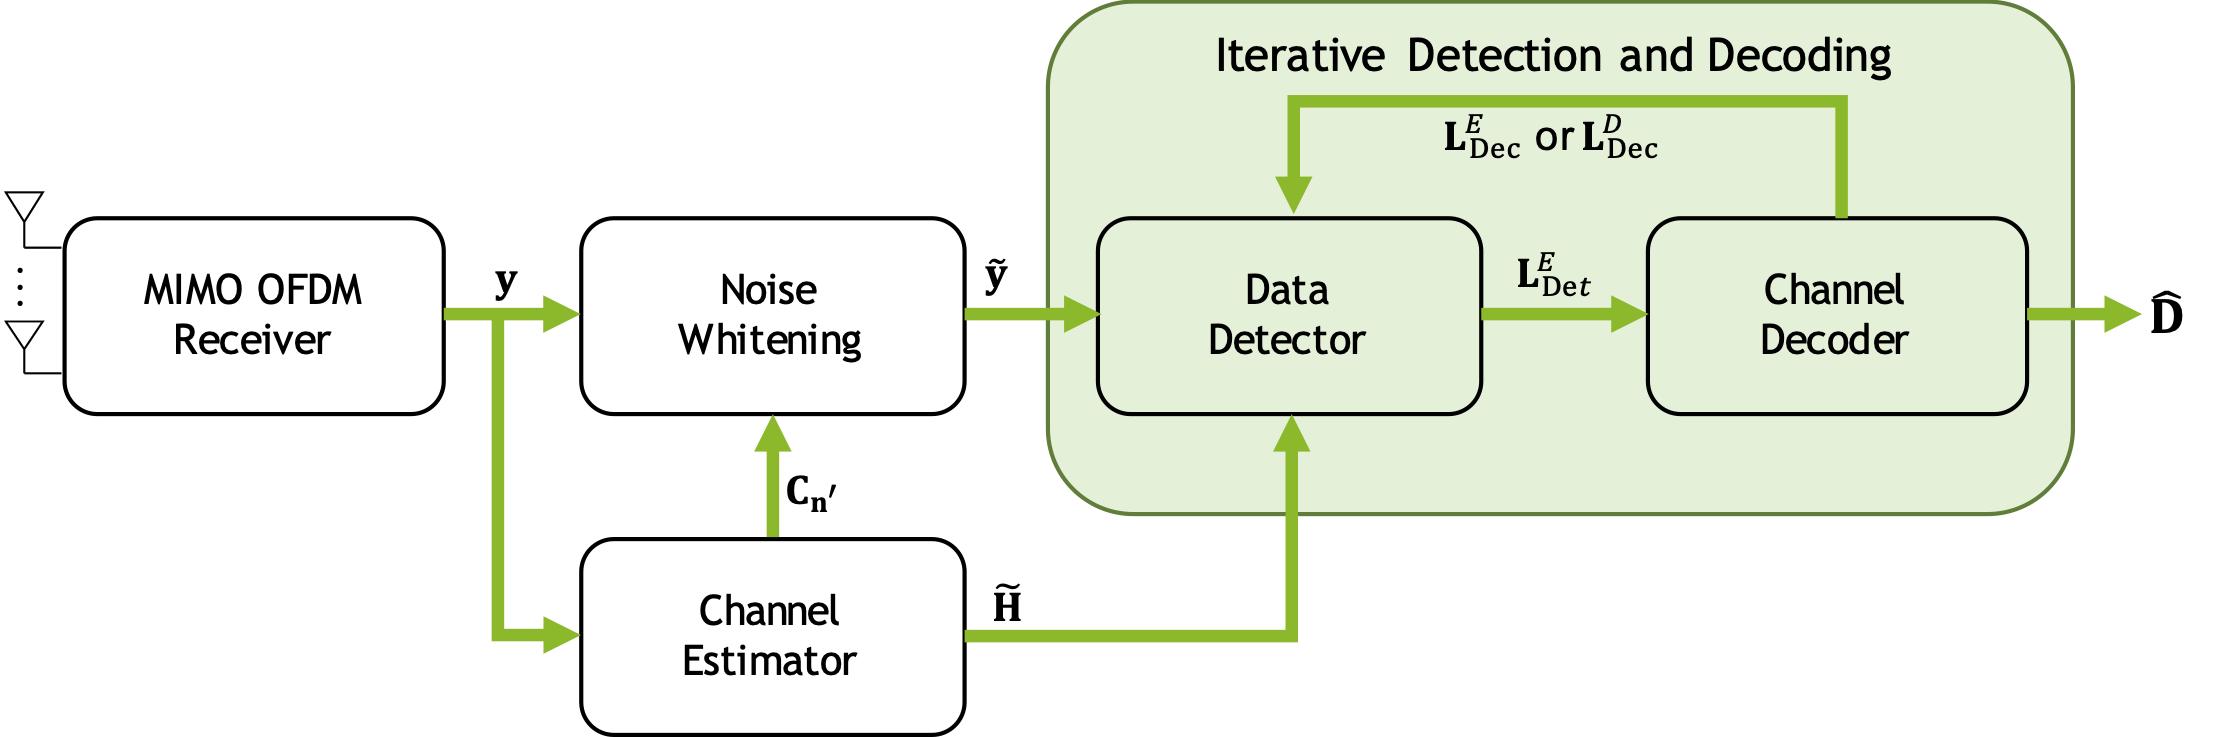

We denote by $\mathrm{L}^{D}$ the *a posteriori* information (represented by log-likelihood ratios, LLRs) and by $\mathrm{L}^{E} = \mathrm{L}^{D} - \mathrm{L}^{A}$ the extrinsic information, which corresponds to the information gain in $\mathrm{L}^{D}$ relative to the *a priori* information $\mathrm{L}^{A}$. The *a priori* LLRs represent soft information, provided to either the input of the detector (i.e., $\mathrm{L}^{A}_{Det}$) or the decoder (i.e., $\mathrm{L}^{A}_{Dec}$). While exchanging extrinsic information is standard for classical IDD, the SISO MMSE-PIC detector [2] turned out to work better when provided with the full *a posteriori* information from the decoder.

Originally, IDD was proposed with a resetting (Turbo) decoder [1]. However, state-of-the-art IDD with LDPC message passing decoding showed better performance with a non-resetting decoder [3], particularly for a low number of decoding iterations. Therefore, we will forward the decoder state (i.e., the check node to variable node messages) from each IDD iteration to the next.

## Table of contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Setting-up the Keras Models](#Setting-up-the-Keras-Models)
* [Non-IDD versus IDD Benchmarks](#Non-IDD-versus-IDD-Benchmarks)
* [Discussion-Optimizing IDD with Machine Learning](#Discussion-Optimizing-IDD-with-Machine-Learning)
* [Comments](#Comments)
* [List of References](#List-of-References)

## GPU Configuration and Imports

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

import tensorflow as tf
from tensorflow.keras import Model
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sionna.mimo import StreamManagement
from sionna.utils import QAMSource, BinarySource, sim_ber, ebnodb2no, QAMSource, expand_to_rank
from sionna.mapping import Mapper, Constellation
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LinearDetector, KBestDetector, EPDetector, \
    RemoveNulledSubcarriers, MMSEPICDetector
from sionna.channel import GenerateOFDMChannel, OFDMChannel, RayleighBlockFading, gen_single_sector_topology
from sionna.channel.tr38901 import UMa, Antenna, PanelArray
from sionna.fec.ldpc import LDPC5GEncoder
from sionna.fec.ldpc import LDPC5GDecoder

sionna.config.seed = 42 # Set seed for reproducible random number generation

## Simulation Parameters
In the following, we set the simulation parameters. Please modify at will; adapting the batch size to your hardware setup might be beneficial.

The standard configuration implements a coded 5G inspired MU-MIMO OFDM uplink transmission over 3GPP UMa channels, with 4 single-antenna UEs, 16-QAM modulation, and a 16 element dual-polarized uniform planar antenna array (UPA) at the gNB. We implement least squares channel estimation with linear interpolation. Alternatively, we implement iid Rayleigh fading channels and perfect channel state information (CSI), which can be controlled by the model parameter `perfect_csi_rayleigh`.
As channel code, we apply a rate-matched 5G LDPC code at rate 1/2.

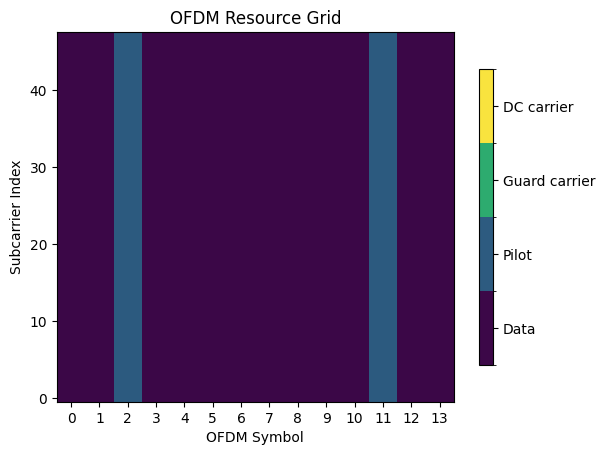

In [2]:
SIMPLE_SIM = False   # reduced simulation time for simple simulation if set to True
if SIMPLE_SIM:
    batch_size = int(1e1)  # number of OFDM frames to be analyzed per batch
    num_iter = 5  # number of Monte Carlo Iterations (total number of Monte Carlo trials is num_iter*batch_size)
    num_steps = 6
    tf.config.run_functions_eagerly(True)   # run eagerly for better debugging
else:
    batch_size = int(64)  # number of OFDM frames to be analyzed per batch
    num_iter = 128  # number of Monte Carlo Iterations (total number of Monte Carlo trials is num_iter*batch_size)
    num_steps = 11

ebno_db_min_perf_csi = -10  # min EbNo value in dB for perfect csi benchmarks
ebno_db_max_perf_csi = 0
ebno_db_min_cest = -10
ebno_db_max_cest = 10


NUM_OFDM_SYMBOLS = 14
FFT_SIZE = 12*4 # 4 PRBs
SUBCARRIER_SPACING = 30e3 # Hz
CARRIER_FREQUENCY = 3.5e9 # Hz
SPEED = 3. # m/s
num_bits_per_symbol = 4 # 16 QAM
n_ue = 4 # 4 UEs
NUM_RX_ANT = 16 # 16 BS antennas
num_pilot_symbols = 2

# The user terminals (UTs) are equipped with a single antenna
# with vertial polarization.
UT_ANTENNA = Antenna(polarization='single',
                     polarization_type='V',
                     antenna_pattern='omni', # Omnidirectional antenna pattern
                     carrier_frequency=CARRIER_FREQUENCY)

# The base station is equipped with an antenna
# array of 8 cross-polarized antennas,
# resulting in a total of 16 antenna elements.
BS_ARRAY = PanelArray(num_rows_per_panel=2,
                      num_cols_per_panel=4,
                      polarization='dual',
                      polarization_type='cross',
                      antenna_pattern='38.901', # 3GPP 38.901 antenna pattern
                      carrier_frequency=CARRIER_FREQUENCY)

# 3GPP UMa channel model is considered
channel_model_uma = UMa(carrier_frequency=CARRIER_FREQUENCY,
                    o2i_model='low',
                    ut_array=UT_ANTENNA,
                    bs_array=BS_ARRAY,
                    direction='uplink',
                    enable_shadow_fading=False,
                    enable_pathloss=False)

channel_model_rayleigh = RayleighBlockFading(num_rx=1, num_rx_ant=NUM_RX_ANT, num_tx=n_ue, num_tx_ant=1)

constellation = Constellation("qam", num_bits_per_symbol=num_bits_per_symbol)

rx_tx_association = np.ones([1, n_ue])
sm = StreamManagement(rx_tx_association, 1)

# Parameterize the OFDM channel
rg = ResourceGrid(num_ofdm_symbols=NUM_OFDM_SYMBOLS, pilot_ofdm_symbol_indices = [2, 11],
                  fft_size=FFT_SIZE, num_tx=n_ue,
                  pilot_pattern = "kronecker",
                  subcarrier_spacing=SUBCARRIER_SPACING)

rg.show()
plt.show()

# Parameterize the LDPC code
R = 0.5  # rate 1/2
N = int(FFT_SIZE * (NUM_OFDM_SYMBOLS - 2) * num_bits_per_symbol)
# N = int((FFT_SIZE) * (NUM_OFDM_SYMBOLS - 2) * num_bits_per_symbol)
# code length; - 12 because of 11 guard carriers and 1 DC carrier, - 2 becaues of 2 pilot symbols
K = int(N * R)  # number of information bits per codeword


## Setting-up the Keras Models

Now, we define the baseline models for benchmarking. Let us start with the non-IDD models.

In [3]:
class NonIddModel(Model):
    def __init__(self, num_bp_iter=12, detector='lmmse', cest_type="LS", interp="lin", perfect_csi_rayleigh=False):
        super().__init__()
        self._num_bp_iter = int(num_bp_iter)
        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(K, N, num_bits_per_symbol=num_bits_per_symbol)
        self._mapper = Mapper(constellation=constellation)
        self._rg_mapper = ResourceGridMapper(rg)

        # Channel
        if perfect_csi_rayleigh:
            self._channel_model = channel_model_rayleigh
        else:
            self._channel_model = channel_model_uma

        self._channel = OFDMChannel(channel_model=self._channel_model,
                                    resource_grid=rg,
                                    add_awgn=True, normalize_channel=True, return_channel=True)
        
        # Receiver
        self._cest_type = cest_type
        self._interp = interp

        # Channel estimation
        self._perfect_csi_rayleigh = perfect_csi_rayleigh
        if self._perfect_csi_rayleigh:
            self._removeNulledSc = RemoveNulledSubcarriers(rg)
        elif cest_type == "LS":
            self._ls_est = LSChannelEstimator(rg, interpolation_type=interp)
        else:
            raise NotImplementedError('Not implemented:' + cest_type)

        # Detection
        if detector == "lmmse":
            self._detector = LinearDetector("lmmse", 'bit', "maxlog", rg, sm, constellation_type="qam",
                                            num_bits_per_symbol=num_bits_per_symbol, hard_out=False)
        elif detector == "k-best":
            k = 64
            self._detector = KBestDetector('bit', n_ue, k, rg, sm, constellation_type="qam",
                                           num_bits_per_symbol=num_bits_per_symbol, hard_out=False)
        elif detector == "ep":
            l = 10
            self._detector = EPDetector('bit', rg, sm, num_bits_per_symbol, l=l, hard_out=False)

        # Forward error correction (decoder)
        self._decoder = LDPC5GDecoder(self._encoder, return_infobits=True, hard_out=True, num_iter=num_bp_iter, cn_type='minsum')

    def new_topology(self, batch_size):
        """Set new topology"""
        if isinstance(self._channel_model, UMa):
            # sensible values according to 3GPP standard, no mobility by default
            topology = gen_single_sector_topology(batch_size,
                                                  n_ue, max_ut_velocity=SPEED,
                                                  scenario="uma")
            self._channel_model.set_topology(*topology)

    @tf.function  # We don't use jit_compile=True to ensure better numerical stability
    def call(self, batch_size, ebno_db):
        self.new_topology(batch_size)

        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)

        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=num_bits_per_symbol,
                       coderate=R)  # normalize in OFDM freq. domain
        b = self._binary_source([batch_size, n_ue, 1, K])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        ######################################
        ## Channel
        # A batch of new channel realizations is sampled and applied at every inference
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y, h = self._channel([x_rg, no_])

        ######################################
        ## Receiver
        if self._perfect_csi_rayleigh:
            h_hat = self._removeNulledSc(h)
            chan_est_var = tf.zeros(tf.shape(h_hat),
                                    dtype=tf.float32)  # No channel estimation error when perfect CSI knowledge is assumed
        else:
            h_hat, chan_est_var = self._ls_est([y, no])

        llr_ch = self._detector((y, h_hat, chan_est_var, no))  # detector
        b_hat = self._decoder((llr_ch))
        return b, b_hat 

Next, we implement the IDD model with a non-resetting LDPC decoder, as in [3], i.e., we forward the LLRs and decoder state from one IDD iteration to the following.

In [4]:
class IddModel(NonIddModel):  # inherited from NonIddModel
    def __init__(self, num_idd_iter=3, num_bp_iter_per_idd_iter=12, cest_type="LS", interp="lin", perfect_csi_rayleigh=False):
        super().__init__(num_bp_iter=num_bp_iter_per_idd_iter, detector="lmmse", cest_type=cest_type,
                         interp=interp, perfect_csi_rayleigh=perfect_csi_rayleigh)
        # first IDD detector is LMMSE as MMSE-PIC with zero-prior bils down to soft-output LMMSE
        self._num_idd_iter = num_idd_iter
        self._siso_detector = MMSEPICDetector(output="bit", resource_grid=rg, stream_management=sm,
                                              demapping_method='maxlog', constellation=constellation, num_iter=1,
                                              hard_out=False)
        self._siso_decoder = LDPC5GDecoder(self._encoder, return_infobits=False,
                                           num_iter=num_bp_iter_per_idd_iter, stateful=True, hard_out=False, cn_type='minsum')
        self._decoder = LDPC5GDecoder(self._encoder, return_infobits=True, stateful=True, hard_out=True, num_iter=num_bp_iter_per_idd_iter, cn_type='minsum')
        # last decoder must also be statefull

    @tf.function  # We don't use jit_compile=True to ensure better numerical stability
    def call(self, batch_size, ebno_db):
        self.new_topology(batch_size)

        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)

        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=num_bits_per_symbol,
                       coderate=R)  # normalize in OFDM freq. domain
        b = self._binary_source([batch_size, n_ue, 1, K])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        ######################################
        ## Channel
        # A batch of new channel realizations is sampled and applied at every inference
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y, h = self._channel([x_rg, no_])

        ######################################
        ## Receiver
        if self._perfect_csi_rayleigh:
            h_hat = self._removeNulledSc(h)
            chan_est_var = tf.zeros(tf.shape(h_hat),
                                    dtype=tf.float32)  # No channel estimation error when perfect CSI knowledge is assumed
        else:
            h_hat, chan_est_var = self._ls_est([y, no])

        llr_ch = self._detector((y, h_hat, chan_est_var, no))  # soft-output LMMSE detection
        msg_vn = None

        if self._num_idd_iter >= 2:
            # perform first iteration outside the while_loop to initialize msg_vn
            [llr_dec, msg_vn] = self._siso_decoder((llr_ch, msg_vn))
            # forward a posteriori information from decoder

            llr_ch = self._siso_detector((y, h_hat, llr_dec, chan_est_var, no))
            # forward extrinsic information

            def idd_iter(llr_ch, msg_vn, it):
                [llr_dec, msg_vn] = self._siso_decoder([llr_ch, msg_vn])
                # forward a posteriori information from decoder
                llr_ch = self._siso_detector((y, h_hat, llr_dec, chan_est_var, no))
                # forward extrinsic information from detector

                it += 1
                return llr_ch, msg_vn, it

            def idd_stop(llr_ch, msg_vn, it):
                return tf.less(it, self._num_idd_iter - 1)

            it = tf.constant(1)     # we already performed initial detection and one full iteration
            llr_ch, msg_vn, it = tf.while_loop(idd_stop, idd_iter, (llr_ch, msg_vn, it), parallel_iterations=1,
                                               maximum_iterations=self._num_idd_iter - 1)
        else:
            # non-idd
            pass

        [b_hat, _] = self._decoder((llr_ch, msg_vn))    # final hard-output decoding (only returning information bits)
        return b, b_hat

## Non-IDD versus IDD Benchmarks

In [5]:
# Range of SNR (dB)
snr_range_cest = np.linspace(ebno_db_min_cest, ebno_db_max_cest, num_steps)
snr_range_perf_csi = np.linspace(ebno_db_min_perf_csi, ebno_db_max_perf_csi, num_steps)

def run_idd_sim(snr_range, perfect_csi_rayleigh):
    lmmse = NonIddModel(detector="lmmse", perfect_csi_rayleigh=perfect_csi_rayleigh)
    k_best = NonIddModel(detector="k-best", perfect_csi_rayleigh=perfect_csi_rayleigh)
    ep = NonIddModel(detector="ep", perfect_csi_rayleigh=perfect_csi_rayleigh)
    idd2 = IddModel(num_idd_iter=2, perfect_csi_rayleigh=perfect_csi_rayleigh)
    idd3 = IddModel(num_idd_iter=3, perfect_csi_rayleigh=perfect_csi_rayleigh)

    ber_lmmse, bler_lmmse = sim_ber(lmmse,
                                    snr_range,
                                    batch_size=batch_size,
                                    max_mc_iter=num_iter,
                                    num_target_block_errors=int(batch_size * num_iter * 0.1))

    ber_ep, bler_ep = sim_ber(ep,
                              snr_range,
                              batch_size=batch_size,
                              max_mc_iter=num_iter,
                              num_target_block_errors=int(batch_size * num_iter * 0.1))

    ber_kbest, bler_kbest = sim_ber(k_best,
                                    snr_range,
                                    batch_size=batch_size,
                                    max_mc_iter=num_iter,
                                    num_target_block_errors=int(batch_size * num_iter * 0.1))

    ber_idd2, bler_idd2 = sim_ber(idd2,
                                  snr_range,
                                  batch_size=batch_size,
                                  max_mc_iter=num_iter,
                                  num_target_block_errors=int(batch_size * num_iter * 0.1))

    ber_idd3, bler_idd3 = sim_ber(idd3,
                                  snr_range,
                                  batch_size=batch_size,
                                  max_mc_iter=num_iter,
                                  num_target_block_errors=int(batch_size * num_iter * 0.1))

    return bler_lmmse, bler_ep, bler_kbest, bler_idd2, bler_idd3


BLER = {}

# Perfect CSI
bler_lmmse, bler_ep, bler_kbest, bler_idd2, bler_idd3 = run_idd_sim(snr_range_perf_csi, perfect_csi_rayleigh=True)
BLER['Perf. CSI / LMMSE'] = bler_lmmse
BLER['Perf. CSI / EP'] = bler_ep
BLER['Perf. CSI / K-Best'] = bler_kbest
BLER['Perf. CSI / IDD2'] = bler_idd2
BLER['Perf. CSI / IDD3'] = bler_idd3

# Estimated CSI
bler_lmmse, bler_ep, bler_kbest, bler_idd2, bler_idd3 = run_idd_sim(snr_range_cest, perfect_csi_rayleigh=False)
BLER['Ch. Est. / LMMSE'] = bler_lmmse
BLER['Ch. Est. / EP'] = bler_ep
BLER['Ch. Est. / K-Best'] = bler_kbest
BLER['Ch. Est. / IDD2'] = bler_idd2
BLER['Ch. Est. / IDD3'] = bler_idd3

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 2.1222e-01 | 1.0000e+00 |      250341 |     1179648 |         1024 |        1024 |         7.4 |reached target block errors
     -9.0 | 1.8605e-01 | 1.0000e+00 |      219468 |     1179648 |         1024 |        1024 |         0.3 |reached target block errors
     -8.0 | 1.1066e-01 | 9.7168e-01 |      130544 |     1179648 |          995 |        1024 |         0.3 |reached target block errors
     -7.0 | 1.6800e-02 | 3.4297e-01 |       49544 |     2949120 |          878 |        2560 |         0.7 |reached target block errors
     -6.0 | 1.1417e-03 | 3.1675e-02 |       34008 |    29786112 |          819 |       25856 |         6.6 |reached target block errors
     -5.0 | 8.7420e-05 | 2.2888e-03 |        3300 |    37748736 |

I0000 00:00:1727373458.780976  366760 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 2.1174e-01 | 1.0000e+00 |      249783 |     1179648 |         1024 |        1024 |         6.6 |reached target block errors
     -9.0 | 1.8487e-01 | 1.0000e+00 |      218083 |     1179648 |         1024 |        1024 |         2.3 |reached target block errors
     -8.0 | 1.1649e-01 | 9.9707e-01 |      137421 |     1179648 |         1021 |        1024 |         2.3 |reached target block errors
     -7.0 | 2.2382e-02 | 5.9570e-01 |       39605 |     1769472 |          915 |        1536 |         3.5 |reached target block errors
     -6.0 | 1.0651e-03 | 5.2702e-02 |       19161 |    17989632 |          823 |       15616 |        35.9 |reached target block errors
     -5.0 | 2.7100e-05 | 1.2207e-03 |        1023 |    37748736 |

Finally, we plot the simulation results and observe that IDD outperforms the non-iterative methods by about 1 dB in the scenario with iid Rayleigh fading channels and perfect CSI. In the scenario with 3GPP UMa channels and estimated CSI, IDD performs slightly better than K-best, at considerably lower runtime.

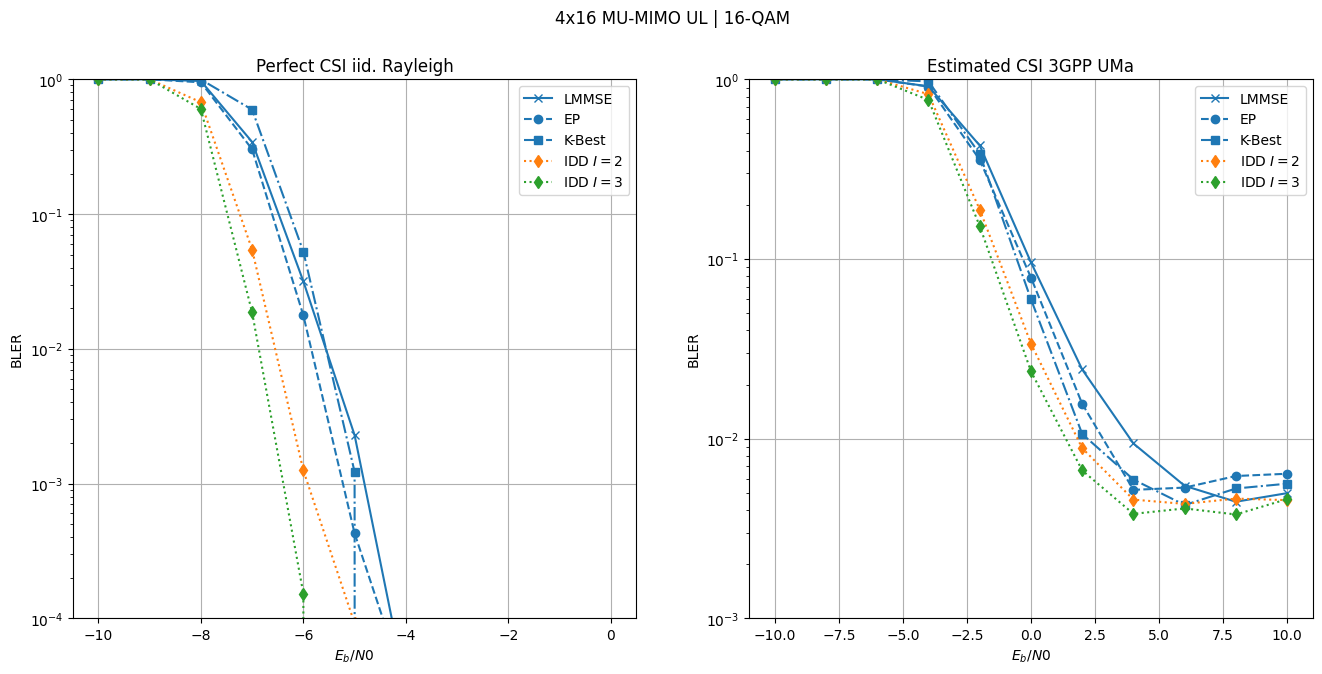

In [6]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
fig.suptitle(f"{n_ue}x{NUM_RX_ANT} MU-MIMO UL | {2**num_bits_per_symbol}-QAM")

## Perfect CSI Rayleigh
ax[0].set_title("Perfect CSI iid. Rayleigh")
ax[0].semilogy(snr_range_perf_csi, BLER['Perf. CSI / LMMSE'], 'x-', label='LMMSE', c='C0')
ax[0].semilogy(snr_range_perf_csi, BLER['Perf. CSI / EP'], 'o--', label='EP', c='C0')
ax[0].semilogy(snr_range_perf_csi, BLER['Perf. CSI / K-Best'], 's-.', label='K-Best', c='C0')
ax[0].semilogy(snr_range_perf_csi, BLER['Perf. CSI / IDD2'], 'd:', label=r'IDD $I=2$', c='C1')
ax[0].semilogy(snr_range_perf_csi, BLER['Perf. CSI / IDD3'], 'd:', label=r'IDD $I=3$', c='C2')

ax[0].set_xlabel(r"$E_b/N0$")
ax[0].set_ylabel("BLER")
ax[0].set_ylim((1e-4, 1.0))
ax[0].legend()
ax[0].grid(True)

## Estimated CSI Rayleigh
ax[1].set_title("Estimated CSI 3GPP UMa")
ax[1].semilogy(snr_range_cest, BLER['Ch. Est. / LMMSE'], 'x-', label='LMMSE', c='C0')
ax[1].semilogy(snr_range_cest, BLER['Ch. Est. / EP'], 'o--', label='EP', c='C0')
ax[1].semilogy(snr_range_cest, BLER['Ch. Est. / K-Best'], 's-.', label='K-Best', c='C0')
ax[1].semilogy(snr_range_cest, BLER['Ch. Est. / IDD2'], 'd:', label=r'IDD $I=2$', c='C1')
ax[1].semilogy(snr_range_cest, BLER['Ch. Est. / IDD3'], 'd:', label=r'IDD $I=3$', c='C2')

ax[1].set_xlabel(r"$E_b/N0$")
ax[1].set_ylabel("BLER")
ax[1].set_ylim((1e-3, 1.0))
ax[1].legend()
ax[1].grid(True)

plt.show()

## Discussion-Optimizing IDD with Machine Learning
Recent work [4] showed that IDD can be significantly improved by deep-unfolding, which applies machine learning to automatically tune hyperparameters of classical algorithms. The proposed *Deep-Unfolded Interleaved Detection and Decoding* method showed performance gains of up to 1.4 dB at the same computational complexity. A link to the simulation code is available in the ["Made with Sionna"](https://nvlabs.github.io/sionna/made_with_sionna.html#duidd-deep-unfolded-interleaved-detection-and-decoding-for-mimo-wireless-systems) section. 

## Comments

- As discussed in [3], IDD receivers with a non-resetting decoder converge faster than with resetting decoders. However, a resetting decoder (which does not forward `msg_vn`) might perform slightly better for a large number of message passing decoding iterations. Among other quantities, a scaling of the forwarded decoder state is optimized in the DUIDD receiver [4].
- With estimated channels, we observed that the MMSE-PIC output LLRs become large, much larger as with non-iterative receive processing.

## List of References

[1] B. Hochwald and S. Ten Brink, [*"Achieving near-capacity on a multiple-antenna channel,"*](https://ieeexplore.ieee.org/abstract/document/1194444) IEEE Trans. Commun., vol. 51, no. 3, pp. 389–399, Mar. 2003.

[2] C. Studer, S. Fateh, and D. Seethaler, [*"ASIC implementation of soft-input soft-output MIMO detection
using MMSE parallel interference cancellation,"*](https://ieeexplore.ieee.org/abstract/document/5779722) IEEE Journal of Solid-State Circuits, vol. 46, no. 7, pp. 1754–1765, Jul. 2011.

[3] W.-C. Sun, W.-H. Wu, C.-H. Yang, and Y.-L. Ueng, [*"An iterative detection and decoding receiver for LDPC-coded MIMO systems,"*](https://ieeexplore.ieee.org/abstract/document/7272776) IEEE Trans. Circuits Syst. I, vol. 62, no. 10, pp. 2512–2522, Oct. 2015.

[4] R. Wiesmayr, C. Dick, J. Hoydis, and C. Studer, [*"DUIDD: Deep-unfolded interleaved detection and decoding for MIMO wireless systems,"*](https://arxiv.org/abs/2212.07816) in Asilomar Conf. Signals, Syst., Comput., Oct. 2022.